### This notebook creates a simple 1 compartment model to simulate PK data and applies it to a set of synthetic patient data.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from functools import partial

sns.set_theme(style="whitegrid")

Define PK parameter values.

In [14]:
# PK parameters in the 1 compartment model with linear elimination
CL = 500  # mL/min - overall clearance term
V = 70000  # mL - total human tissue volume
Dose = 500  # mg - no particular drug
k_e = CL / V  # min^-1 - elimination constant
C_0 = Dose / V  # mg/mL - initial concentration

Define ODE and solve for a single patient, plotting the results.

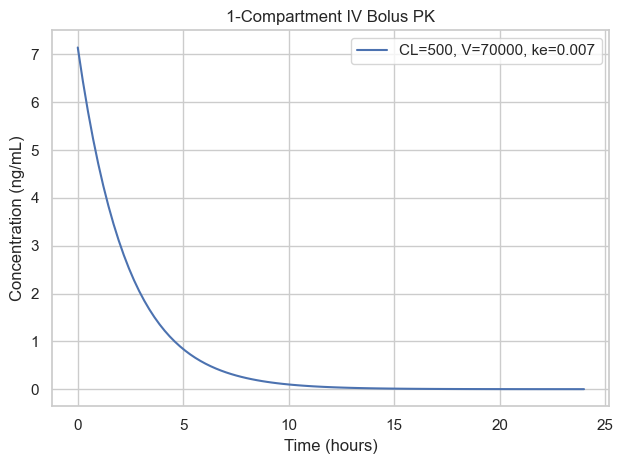

In [15]:
# Define function for change in concentration over time
def ivbolus(t, y):
    C = y[0]  # y is list, take 1st compartment, so first item in list
    dCdt = -CL / V * C
    return [dCdt]


t_span = (0, 24 * 60)  # Simulate for 1 day converted to mins
t_eval = np.linspace(0, 24 * 60, 100)  # Specify number of time points and when

# Solve simple system using numerical solver
sol = solve_ivp(fun=ivbolus, t_span=t_span, y0=[C_0], t_eval=t_eval, method="Radau")

# Convert timeframe to hours from mins
sol.t /= 60

# Convert y values to ng/mL
sol.y *= 1000

# Create the plot
plt.plot(sol.t, sol.y[0], label=f"CL={CL}, V={V}, ke={k_e:.3f}")
plt.xlabel("Time (hours)")
plt.ylabel("Concentration (ng/mL)")
plt.title("1-Compartment IV Bolus PK")
plt.legend()
plt.tight_layout()
plt.show()

To increase complexity, multiple patients can be simulated by introducing log-normal variability.

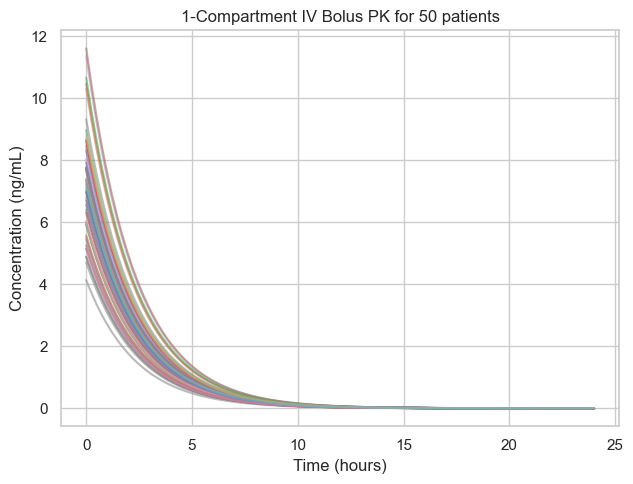

In [16]:
def simulate_patient(CL_mean=500, V_mean=70000, CV=0.25):

    CL = np.random.lognormal(mean=np.log(CL_mean), sigma=CV)
    V = np.random.lognormal(mean=np.log(V_mean), sigma=CV)
    C0 = Dose / V

    sol = solve_ivp(
        fun=ivbolus,
        t_span=(0, 24 * 60),
        y0=[C0],
        t_eval=np.linspace(0, 24 * 60, 100),
        method="Radau",
    )

    return sol.t, sol.y[0], CL, V


# Simulate 20 patients
patients = []
for i in range(50):
    np.random.seed(i + 1)
    t, C, CL_i, V_i = simulate_patient()
    patients.append({"time": t / 60, "concentration": C * 1000, "CL": CL_i, "V": V_i})
    np.random.seed(i + 1)

# Plot results
plt.figure(figsize=(6.5, 5))
for p in patients:
    plt.plot(p["time"], p["concentration"], alpha=0.6)
plt.xlabel("Time (hours)")
plt.ylabel("Concentration (ng/mL)")
plt.title("1-Compartment IV Bolus PK for 50 patients")
plt.tight_layout()
plt.show()

The mean of this data can be plotted, with the variance plotted as the shaded area.

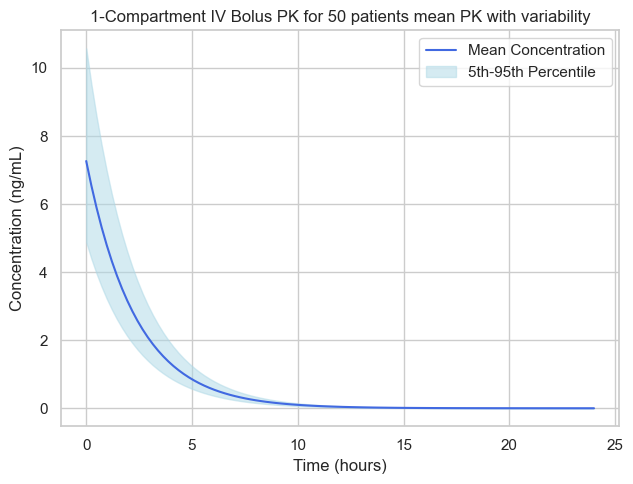

In [17]:
# Collate concentration profiles
all_concs = np.array([p["concentration"] for p in patients])
time = patients[0]["time"]

# Compute mean and bounds
mean_conc = np.mean(all_concs, axis=0)
lower_bound = np.percentile(all_concs, 5, axis=0)
upper_bound = np.percentile(all_concs, 95, axis=0)

# Plot the initial figure and mean
plt.figure(figsize=(6.5, 5))
plt.plot(time, mean_conc, color="royalblue", linewidth=1.5, label="Mean Concentration")

# Shaded area for 5 and 95 % percentiles
plt.fill_between(
    time,
    lower_bound,
    upper_bound,
    color="lightblue",
    alpha=0.5,
    label="5th-95th Percentile",
)

# Labels and legend
plt.xlabel("Time (hours)")
plt.ylabel("Concentration (ng/mL)")
plt.title("1-Compartment IV Bolus PK for 50 patients mean PK with variability")
plt.legend()
plt.tight_layout()
# plt.savefig("../data/iv_bolus_PK_mean.png")
plt.show()


Noise can now be added to model assay error.

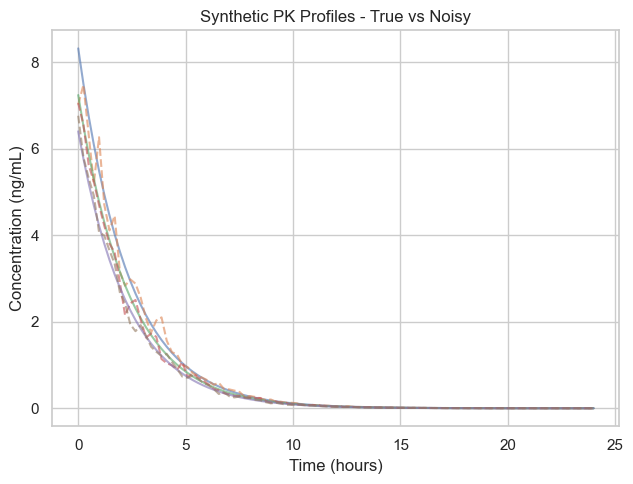

In [18]:
# Define function for proportional Gaussian noise to avoid going below 0
def add_noise(concentration, CV=0.1):
    SD = CV * concentration
    noise = np.random.normal(0, SD)
    noise += concentration
    return np.clip(noise, 0, None)


# Add noise
for p in patients:
    p["conc_noisy"] = add_noise(p["concentration"])

# Plot the results
plt.figure(figsize=(6.5, 5))
for i in range(3):
    np.random.seed(i + 1)
    p = patients[i]
    plt.plot(p["time"], p["concentration"], label=f"Patient {i+1} (True)", alpha=0.6)
    plt.plot(
        p["time"], p["conc_noisy"], "--", label=f"Patient {i+1} (Noisy)", alpha=0.6
    )
plt.xlabel("Time (hours)")
plt.ylabel("Concentration (ng/mL)")
plt.title("Synthetic PK Profiles - True vs Noisy")
# plt.legend()
plt.tight_layout()
plt.show()